# Goal: To see if an areas Social Vulnerability Index score correlates to an area's amount of crime

#### Intended Result: to walk away with some understanding of if certian types of crime correlate to an areas level of vulnerability

###### Background: Social Vulnerability Index (SVI)

The Socially Vulnerable Population Analysis uses measurements of a geographical area's relative level of vulnerability across multiple variables measure by the American Community Survey. These measurements are derived from The Center for Disease Control's 2016 Social Vulnerability Index (SVI).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark

Lets read in the data from some csv files

In [2]:
df = pd.read_csv('clean_crime_data.csv',dtype = {'zip_code':object})
svi = pd.read_csv('census-data/svi_data.csv', dtype = {'zip':object})

Right now the data is structured very similar to how an excel file is structured. We are going to turn the two dataframes into spark dataframes, which is something that is really useful for working with large data sets (due to computational reasons). This is kind of overkill for these datasets, but its cool and will also allow us to query these data.

In [3]:
spark = pyspark.sql.SparkSession.builder.appName('pandasToSparkDF').getOrCreate()

# create spark dataframes
crime_df = spark.createDataFrame(df)
svi_df = spark.createDataFrame(svi)

# write them to a database
for name, data in zip(['crime','svi'],[crime_df,svi_df]):
    data.createOrReplaceTempView(str(name))

In [4]:
agg_crime = spark.sql("""
select * from 
    (select 
    zip_code,
    count(distinct crime_id) as total_crimes,
    sum(dvflag) as total_dv_flags,  
    sum(firearm_used_flag) as total_firearm_flags, 
    sum(male_arr) as total_male_arr, 
    sum(female_arr) as total_female_arr,
    sum(black_race_flag) as black_race_flag_arr, 
    sum(unknown_race_flag) as unkown_race_flag_arr,
    sum(white_race_flag) as white_race_flag_arr, 
    sum(asian_race_flag) as asian_race_flag_arr, 
    sum(indian_race_flag) as indian_race_flag_arr,
    sum(pacific_race_flag) as pacific_race_flag_arr, 
    sum(age_minor) as minor_arr, 
    sum(age_18_24) as age_18_24_arr, 
    sum(age_25_29) as age_25_29_arr, 
    sum(age_30_34) as age_30_34_arr,
    sum(age_35_39) as age_35_39_arr, 
    sum(age_40_44) as age_40_44_arr, 
    sum(age_45_49) as age_45_49_arr, 
    sum(age_50_plus) as age_50_plus_arr, 
    sum(total_vic) as total_victims,
    sum(male_vic) as total_male_victims, 
    sum(female_vic) as total_female_victims
from crime
group by 1)a
join svi s
    on s.zip = a.zip_code

""").toPandas()

Lets see how the aggregate SVI scores of the areas in KC we are looking at are distributed

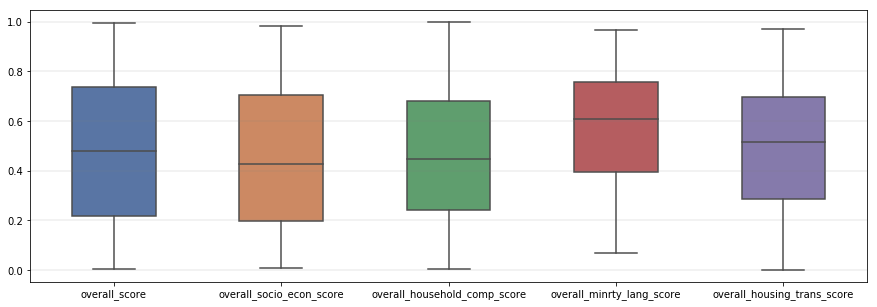

In [5]:
dist = pd.DataFrame(agg_crime[['rpl_themes','rpl_theme1','rpl_theme2','rpl_theme3','rpl_theme4']].describe())
dist.rename(columns = {'rpl_themes':'overall_score',
                      'rpl_theme1':'overall_socio_econ_score',
                      'rpl_theme2':'overall_household_comp_score',
                      'rpl_theme3':'overall_minrty_lang_score',
                      'rpl_theme4':'overall_housing_trans_score'},inplace = True)
d = dist.iloc[[1,3,4,5,6,7]]

plt.figure(figsize=(15, 5))
plt.grid(color='gray', linestyle='-', linewidth=2, alpha = .1)
bplot = sns.boxplot(data=d,
                    width=0.5,
                    palette="deep")

It looks like KC is pretty average as far as our SVI Scores for various zipcodes. We do have a fairly good distribution.

Going to use a spearman correlation because one varible we are measuring, crime (and its various attributes) is continous while the SVI data is ordinal.

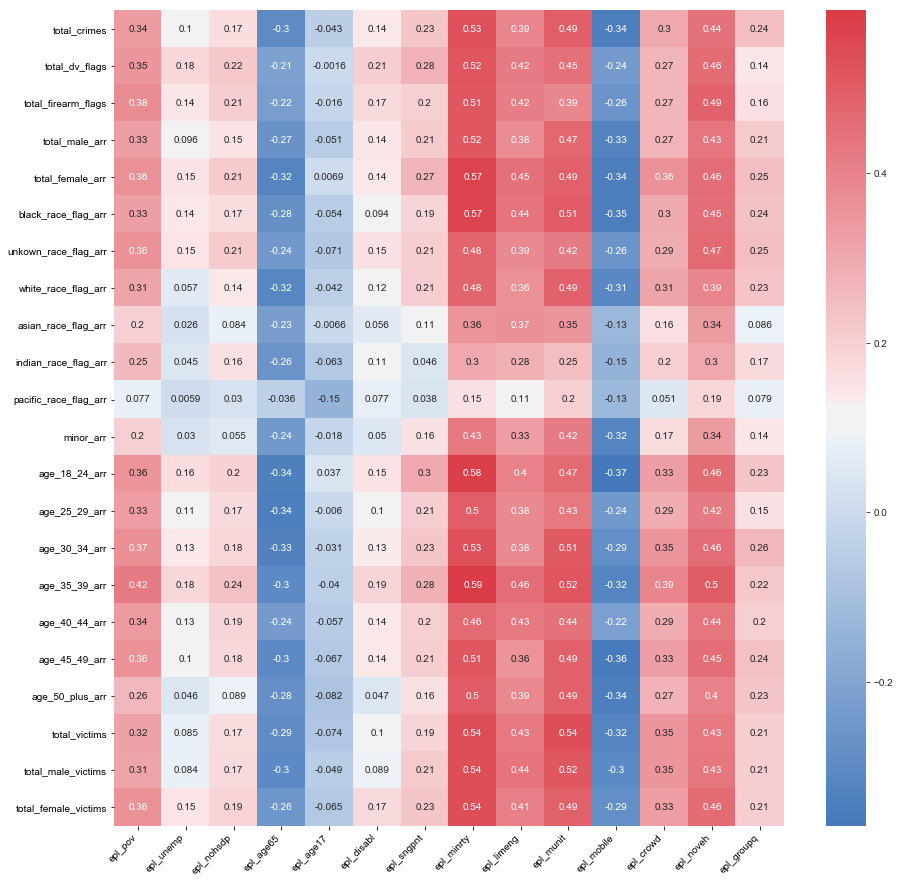

In [6]:
corr = agg_crime.corr(method='spearman',)

c = corr.loc['total_crimes':'total_female_victims','epl_pov':'epl_groupq']

plt.figure(figsize=(15, 15))
plt.xticks(np.arange(len(c)), rotation=45, ha='right')
sns.set_style(style = 'white')
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(c, 
            xticklabels=c.columns.values,
            yticklabels=c.index.values,
            annot = True,
           cmap = cmap)
